In [1]:
from google.cloud import bigquery
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [27]:
client = bigquery.Client()

/home/raphi/.local/share/virtualenvs/code_example-tYeYzoY4/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/home/raphi/.local/share/virtualenvs/code_example-tYeYzoY4/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you

In [50]:
from_dt = datetime.datetime(2022,3,15)  # START-DT VALIDATION-PERIOD (AT LEAST TWO WEEKS)
to_dt =datetime.datetime(2022,3,30) # END-DT VALIDATION PERIOD (AT LEAST TWO WEEKS)
baseline_model_name="model_20220503_121243_long"  # PROVIDE NAME OF BIGQUERY-TABLE CONTAINING THE BASELINE-MODEL (LONG-FORMAT) 
evaluation_model_name="model_20220610_090954_long"  # PROVIDE NAME OF BIGQUERY-TABLE CONTAINING THE MODEL, WHICH SHOULD BE EVALUATED (LONG-FORMAT) 
data_size = 0 # if 0 --> load all data; else limit data to data_size

In [31]:
def load_data_from_bigquery(query_generator, project_id='adtrac-data-and-analytics'):
    """
        Collect Data from BigQuery, store it locally
        Return Pandas Dataframe
    """

    # _set_gcp_credentials()
    bigquery_client = bigquery.Client(project=project_id)

    query = query_generator()
    # Collect data from BigQuery
    query_job = bigquery_client.query(query)
    df = query_job.to_dataframe()
    print('Successfully collected data from BigQuery.')

    return df

In [59]:
def load_data_by_partition(from_dt, to_dt, baseline_model_name, evaluation_model_name, data_size):
    """
        Load the data from using the BigQuery-connector
        use partitions of 2 days since the load of data is heavy
    """

    columns = ['calendar_dt', 'hour_local', 'calendar_dt_hour', 'poi_id', 'provider_id', 'target_group_id',
               'desc_gender', 'desc_age', 'min_age', 'age_bucketized', 'is_special_dt',
               'is_open', 'is_in_validation', 'num_tracking',
               'prediction_type_baseline', 'prediction_type_evaluation',
               'prediction_baseline', 'prediction_evaluation']
    base_df = pd.DataFrame(columns=columns)  # empty dataframe, which will be filled iteratively

    partitions = pd.date_range(start=from_dt, end=to_dt, freq='2D').to_list()

    # create partitions
    for idx in range(len(partitions)):
        start_dt = str(partitions[idx].date())
        print("partition start_dt", start_dt)
        if idx < len(partitions) - 1:
            end_dt = partitions[idx + 1] - datetime.timedelta(days=1)
        else:
            end_dt = to_dt
        end_dt = str(end_dt.date())
        print("partition end_dt", end_dt)

        base_df_new_partition = load_data_from_bigquery(
            _create_pre_update_sql(start_dt, end_dt, data_size))

        base_df = pd.concat([base_df, base_df_new_partition])

    return base_df


In [53]:
def _create_year_week_sql(from_dt, to_dt, baseline_model_name, evaluation_model_name, data_size):
    """
        Create query_string
        Calculate averages for records not in the baseline- and/or evaluation-model
        Only provider_id 6
        Only opening-hours (special_dts already taken into account)
        Only values where the evaluation-model is applicable
        Aggregates actual_values and predictions per year_week between from_dt and to_dt
        Return query_string
    """

    query = f"""
    with 
date_filter as
(
select event_dt from  unnest(generate_date_array(Date "{from_dt}", date "{to_dt}")) as event_dt
),
actual_trackings as 
(
select calendar_dt, hour_local,poi_id, provider_id, target_group_id, num_tracking from `aggregates.trackings_aggregated_1H` tr
join date_filter df on tr.calendar_dt = df.event_dt
),
opening_hours as
(
  select poi_id, provider_id, dayofweek, open_hour from (
    select open.poi_id, open.provider_id, dayofweek, open_hour  from `configurations.opening_hours` open cross join            unnest(open.open_hours) as  open_hour ) 

), special_dt as 
(
  select poi_id, provider_id, calendar_dt as special_dt from `adtrac-data-and-analytics.configurations.special_opening_hours`
  group by poi_id, provider_id, calendar_dt

),model_baseline as
(
select pred.* from `models.{baseline_model_name}` pred
join date_filter df on pred.calendar_dt = df.event_dt
),model_evaluation as
(
select pred.* from `adtrac-data-and-analytics.models.{evaluation_model_name}`  pred
join date_filter df on pred.calendar_dt = df.event_dt
),relevant_pois
as
    (
select poi_id, provider_id from `configurations.pois` pois 
where pois.inactive = 0
), lhs as (
select date.calendar_dt,hour.hour_local ,poi.poi_id, poi.provider_id, tgt.target_group_id  from 
(select calendar_dt from unnest(GENERATE_DATE_ARRAY('{from_dt}', '{to_dt}', INTERVAL 1 DAY)) as calendar_dt) date
cross join `configurations.target_groups` tgt
cross join (select hour_local from unnest(generate_array(0,23,1)) as hour_local)  hour
join (select pois.poi_id, pois.provider_id,sites.batch_import_dt  from `configurations.pois` pois 
      join `configurations.sites` sites on pois.site_id = sites.site_id and pois.provider_id= sites.provider_id) poi on date.calendar_dt >= poi.batch_import_dt 
join relevant_pois on poi.poi_id = relevant_pois.poi_id  and poi.provider_id = relevant_pois.provider_id 
),base_table as
(
  select base.calendar_dt, base.hour_local,
  concat(cast(calendar_dt as string)," ", cast(format("%02d", hour_local) as String),":00") as calendar_dt_hour,
  CAST(FORMAT_DATE('%u',  base.calendar_dt) AS NUMERIC) -1 as dayofweek, format_date('%Y%m', calendar_dt) as year_month,format_date('%Y%W', calendar_dt) as year_week, base.poi_id, base.provider_id, base.target_group_id, pm.inactive, 
  pm.poi_name, pm.provider_name, pm.site_name, pm.state_code , pm.country_code ,
  pm.poi_id_name,
  tgt.desc_gender, tgt.desc_age , tgt.min_age,
  case when tgt.min_age is null then 'unknown'
       when tgt.min_age >= 0 and tgt.min_age<= 10 then 'kids'
       when tgt.min_age between 15 and 30 then 'young_adults'
       when tgt.min_age between 35 and 60 then 'adults'
       when tgt.min_age >= 65 then 'pensioner'
       end as age_bucketized
    , case when sp.special_dt is not null then 1 else 0 end as is_special_dt
    , case when open_hour.open_hour is not null and  sp.special_dt is null then 1 else 0 end is_open -- takes opening-hours and special-dt into account
  from lhs base 
  join date_filter df on base.calendar_dt = df.event_dt
  join `adtrac-data-and-analytics.configurations.poi_mapping` pm on base.poi_id = pm.poi_id and base.provider_id = pm.provider_id and pm.inactive = 0
   join `configurations.target_groups` tgt on tgt.target_group_id = base.target_group_id
left join opening_hours open_hour on open_hour.poi_id = base.poi_id and open_hour.provider_id = base.provider_id and open_hour.dayofweek = CAST(FORMAT_DATE('%u',  base.calendar_dt) AS NUMERIC) -1 and open_hour.open_hour = base.hour_local
left join special_dt as sp on sp.poi_id = base.poi_id and sp.provider_id = base.provider_id and sp.special_dt  = base.calendar_dt
where base.provider_id in (6)
),model_baseline_prediction as 
(
select base.calendar_dt,base.hour_local, base.poi_id, base.provider_id, base.target_group_id,
case when ml.prediction is null then 'average' else 'prediction' end as prediction_type,
case when base.is_open = 0 then coalesce(ml.prediction,0)
    when base.is_open = 1 then coalesce(coalesce(ml.prediction,l.avg_prediction_provider),0)
    end as prediction
from base_table  base
left join model_baseline ml 
   on ml.calendar_dt = base.calendar_dt 
    and ml.poi_id = base.poi_id 
    and ml.provider_id = base.provider_id 
    and ml.hour_local = base.hour_local 
    and ml.target_group_id = base.target_group_id
left join (select calendar_dt, hour_local, m.provider_id, target_group_id, round(avg(prediction)) as avg_prediction_provider from model_baseline m
        join opening_hours open_hour on open_hour.poi_id = m.poi_id and open_hour.provider_id = m.provider_id and open_hour.dayofweek = CAST(FORMAT_DATE('%u',  m.calendar_dt) AS NUMERIC) -1 and open_hour.open_hour = m.hour_local

  group by calendar_dt, hour_local, provider_id, target_group_id ) l
  on base.calendar_dt = l.calendar_dt
    and base.hour_local = l.hour_local
    and base.provider_id = l.provider_id
    and base.target_group_id = l.target_group_id 
) ,model_evaluation_prediction as 
(
select base.calendar_dt,base.hour_local, base.poi_id, base.provider_id, base.target_group_id,
case when ml.prediction is null then 'average' else 'prediction' end as prediction_type,
case when base.is_open = 0 then coalesce(ml.prediction,0)
    when base.is_open = 1 then coalesce(coalesce(ml.prediction,l.avg_prediction_provider),0) 
    end as prediction
from base_table  base
left join model_evaluation ml 
   on ml.calendar_dt = base.calendar_dt 
    and ml.poi_id = base.poi_id 
    and ml.provider_id = base.provider_id 
    and ml.hour_local = base.hour_local 
    and ml.target_group_id = base.target_group_id
left join (select calendar_dt, hour_local, m.provider_id, target_group_id, round(avg(prediction)) as avg_prediction_provider from model_evaluation m
        join opening_hours open_hour on open_hour.poi_id = m.poi_id and open_hour.provider_id = m.provider_id and open_hour.dayofweek = CAST(FORMAT_DATE('%u',  m.calendar_dt) AS NUMERIC) -1 and open_hour.open_hour = m.hour_local

  group by calendar_dt, hour_local, provider_id, target_group_id ) l
  on base.calendar_dt = l.calendar_dt
    and base.hour_local = l.hour_local
    and base.provider_id = l.provider_id
    and base.target_group_id = l.target_group_id 
),complete_data as (
 select base.year_week , base.calendar_dt, base.hour_local, base.calendar_dt_hour ,base.poi_id, base.provider_id, base.target_group_id, base.desc_gender, base.min_age, base.age_bucketized, base.is_special_dt, base.is_open
,mb.prediction_type as prediction_type_baseline
,me.prediction_type as prediction_type_evaluation
, case when is_open = 1 then  tr.num_tracking else 0 end as num_tracking --set value to 0 outside opening-hours
, case when is_open = 1 then mb.prediction else 0 end as prediction_baseline --set value to 0 outside opening-hours
, case when is_open = 1 then me.prediction else 0 end as prediction_evaluation --set value to 0 outside opening-hours
from base_table base
left join actual_trackings tr 
  on tr.calendar_dt = base.calendar_dt 
  and tr.hour_local = base.hour_local 
  and tr.poi_id = base.poi_id 
  and tr.provider_id =  base.provider_id 
  and tr.target_group_id = base.target_group_id 
left join model_baseline_prediction mb 
   on mb.calendar_dt = base.calendar_dt 
  and mb.hour_local = base.hour_local 
  and mb.poi_id = base.poi_id 
  and mb.provider_id =  base.provider_id 
  and mb.target_group_id = base.target_group_id  
left join model_evaluation_prediction me
on me.calendar_dt = base.calendar_dt 
  and me.hour_local = base.hour_local 
  and me.poi_id = base.poi_id 
  and me.provider_id =  base.provider_id 
  and me.target_group_id = base.target_group_id  
)  
select year_week ,sum(num_tracking) as num_tracking, sum(prediction_baseline) as prediction_baseline , sum(prediction_evaluation) as prediction_evaluation from complete_data
where is_open = 1
and target_group_id <> 41
and prediction_type_evaluation = 'prediction'
group by year_week 
order by 1



"""
    if data_size > 0:
        query = query + f""" limit {data_size} """
    return query

In [54]:
def _create_base_sql(from_dt, to_dt, baseline_model_name, evaluation_model_name, data_size):
    """
        Create query_string
        Calculate averages for records not in the baseline- and/or evaluation-model
        Only provider_id 6
        Only opening-hours (special_dts already taken into account)
        Only values where the evaluation-model is applicable
        Return query_string
    """

    query = f"""
    with 
validation_date_filter as
(
select Date "{from_dt}" as from_dt , Date "{to_dt}" as to_dt
),
actual_trackings as 
(
select calendar_dt, hour_local,poi_id, provider_id, target_group_id, num_tracking from `aggregates.trackings_aggregated_1H` tr
join  validation_date_filter df on tr.calendar_dt between df.from_dt and df.to_dt
), opening_hours as
(
  select poi_id, provider_id, dayofweek, open_hour from (
    select open.poi_id, open.provider_id, dayofweek, open_hour  from `configurations.opening_hours` open cross join            unnest(open.open_hours) as  open_hour ) 

), special_dt as 
(
  select poi_id, provider_id, calendar_dt as special_dt from `adtrac-data-and-analytics.configurations.special_opening_hours`
  group by poi_id, provider_id, calendar_dt

),model_baseline as
(
select pred.* from `models.{baseline_model_name}` pred
join  validation_date_filter df on pred.calendar_dt between df.from_dt and df.to_dt
),model_evaluation as
(
select pred.* from `adtrac-data-and-analytics.models.{evaluation_model_name}`  pred
join  validation_date_filter df on pred.calendar_dt between df.from_dt and df.to_dt
),relevant_pois
as
    (
select poi_id, provider_id from `configurations.pois` pois 
where pois.inactive = 0
), lhs as (
select date.calendar_dt,hour.hour_local ,poi.poi_id, poi.provider_id, tgt.target_group_id  from 
(select calendar_dt from unnest(GENERATE_DATE_ARRAY('{from_dt}', '{to_dt}', INTERVAL 1 DAY)) as calendar_dt) date
cross join `configurations.target_groups` tgt
cross join (select hour_local from unnest(generate_array(0,23,1)) as hour_local)  hour
join (select pois.poi_id, pois.provider_id,sites.batch_import_dt  from `configurations.pois` pois 
      join `configurations.sites` sites on pois.site_id = sites.site_id and pois.provider_id= sites.provider_id) poi on date.calendar_dt >= poi.batch_import_dt 
join relevant_pois on poi.poi_id = relevant_pois.poi_id  and poi.provider_id = relevant_pois.provider_id 
),base_table as
(
  select base.calendar_dt, base.hour_local,
  concat(cast(calendar_dt as string)," ", cast(format("%02d", hour_local) as String),":00") as calendar_dt_hour,
  CAST(FORMAT_DATE('%u',  base.calendar_dt) AS NUMERIC) -1 as dayofweek, format_date('%Y%m', calendar_dt) as year_month,format_date('%Y%W', calendar_dt) as year_week, base.poi_id, base.provider_id, base.target_group_id, pm.inactive, 
  pm.poi_name, pm.provider_name, pm.site_name, pm.state_code , pm.country_code ,
  pm.poi_id_name,
  tgt.desc_gender, tgt.desc_age , tgt.min_age,
  case when tgt.min_age is null then 'unknown'
       when tgt.min_age >= 0 and tgt.min_age<= 10 then 'kids'
       when tgt.min_age between 15 and 30 then 'young_adults'
       when tgt.min_age between 35 and 60 then 'adults'
       when tgt.min_age >= 65 then 'pensioner'
       end as age_bucketized
    , case when sp.special_dt is not null then 1 else 0 end as is_special_dt
    , case when open_hour.open_hour is not null and  sp.special_dt is null then 1 else 0 end is_open -- takes opening-hours and special-dt into account
  ,validation_date_filter.from_dt as validation_from_dt, validation_date_filter.to_dt as validation_to_dt
  , case when calendar_dt between validation_date_filter.from_dt and  validation_date_filter.to_dt then 1 else 0 end as is_in_validation
  from lhs base 
  join validation_date_filter df on base.calendar_dt between df.from_dt and df.to_dt
  join `adtrac-data-and-analytics.configurations.poi_mapping` pm on base.poi_id = pm.poi_id and base.provider_id = pm.provider_id and pm.inactive = 0
   join `configurations.target_groups` tgt on tgt.target_group_id = base.target_group_id
left join opening_hours open_hour on open_hour.poi_id = base.poi_id and open_hour.provider_id = base.provider_id and open_hour.dayofweek = CAST(FORMAT_DATE('%u',  base.calendar_dt) AS NUMERIC) -1 and open_hour.open_hour = base.hour_local
left join special_dt as sp on sp.poi_id = base.poi_id and sp.provider_id = base.provider_id and sp.special_dt  = base.calendar_dt
cross join validation_date_filter 
where base.provider_id in (6)
),model_baseline_prediction as 
(
select base.calendar_dt,base.hour_local, base.poi_id, base.provider_id, base.target_group_id,
case when ml.prediction is null then 'average' else 'prediction' end as prediction_type,
case when base.is_open = 0 then coalesce(ml.prediction,0)
    when base.is_open = 1 then coalesce(coalesce(ml.prediction,l.avg_prediction_provider),0)
    end as prediction
from base_table  base
left join model_baseline ml 
   on ml.calendar_dt = base.calendar_dt 
    and ml.poi_id = base.poi_id 
    and ml.provider_id = base.provider_id 
    and ml.hour_local = base.hour_local 
    and ml.target_group_id = base.target_group_id
left join (select calendar_dt, hour_local, m.provider_id, target_group_id, round(avg(prediction)) as avg_prediction_provider from model_baseline m
        join opening_hours open_hour on open_hour.poi_id = m.poi_id and open_hour.provider_id = m.provider_id and open_hour.dayofweek = CAST(FORMAT_DATE('%u',  m.calendar_dt) AS NUMERIC) -1 and open_hour.open_hour = m.hour_local

  group by calendar_dt, hour_local, provider_id, target_group_id ) l
  on base.calendar_dt = l.calendar_dt
    and base.hour_local = l.hour_local
    and base.provider_id = l.provider_id
    and base.target_group_id = l.target_group_id 
) ,model_evaluation_prediction as 
(
select base.calendar_dt,base.hour_local, base.poi_id, base.provider_id, base.target_group_id,
case when ml.prediction is null then 'average' else 'prediction' end as prediction_type,
case when base.is_open = 0 then coalesce(ml.prediction,0)
    when base.is_open = 1 then coalesce(coalesce(ml.prediction,l.avg_prediction_provider),0) 
    end as prediction
from base_table  base
left join model_evaluation ml 
   on ml.calendar_dt = base.calendar_dt 
    and ml.poi_id = base.poi_id 
    and ml.provider_id = base.provider_id 
    and ml.hour_local = base.hour_local 
    and ml.target_group_id = base.target_group_id
left join (select calendar_dt, hour_local, m.provider_id, target_group_id, round(avg(prediction)) as avg_prediction_provider from model_evaluation m
        join opening_hours open_hour on open_hour.poi_id = m.poi_id and open_hour.provider_id = m.provider_id and open_hour.dayofweek = CAST(FORMAT_DATE('%u',  m.calendar_dt) AS NUMERIC) -1 and open_hour.open_hour = m.hour_local

  group by calendar_dt, hour_local, provider_id, target_group_id ) l
  on base.calendar_dt = l.calendar_dt
    and base.hour_local = l.hour_local
    and base.provider_id = l.provider_id
    and base.target_group_id = l.target_group_id 
),complete_data as (
 select base.calendar_dt, base.hour_local, base.calendar_dt_hour ,base.poi_id, base.provider_id, base.target_group_id, base.desc_gender, base.min_age, base.age_bucketized, base.is_special_dt, base.is_open
,mb.prediction_type as prediction_type_baseline
,me.prediction_type as prediction_type_evaluation
, case when is_open = 1 then  tr.num_tracking else 0 end as num_tracking --set value to 0 outside opening-hours
, case when is_open = 1 then mb.prediction else 0 end as prediction_baseline --set value to 0 outside opening-hours
, case when is_open = 1 then me.prediction else 0 end as prediction_evaluation --set value to 0 outside opening-hours
from base_table base
left join actual_trackings tr 
  on tr.calendar_dt = base.calendar_dt 
  and tr.hour_local = base.hour_local 
  and tr.poi_id = base.poi_id 
  and tr.provider_id =  base.provider_id 
  and tr.target_group_id = base.target_group_id 
left join model_baseline_prediction mb 
   on mb.calendar_dt = base.calendar_dt 
  and mb.hour_local = base.hour_local 
  and mb.poi_id = base.poi_id 
  and mb.provider_id =  base.provider_id 
  and mb.target_group_id = base.target_group_id  
left join model_evaluation_prediction me
on me.calendar_dt = base.calendar_dt 
  and me.hour_local = base.hour_local 
  and me.poi_id = base.poi_id 
  and me.provider_id =  base.provider_id 
  and me.target_group_id = base.target_group_id  
)  
select * from complete_data
where is_open = 1
and prediction_type_evaluation = 'prediction'

"""
    if data_size > 0:
        query = query + f""" limit {data_size} """
    return query


In [58]:
def _create_pre_update_sql(from_dt, to_dt, data_size):

    query = f"""
    with 
validation_date_filter as
(
select Date "{from_dt}" as from_dt , Date "{to_dt}" as to_dt
),
actual_trackings as 
(
select calendar_dt, hour_local,poi_id, provider_id, target_group_id, num_tracking from `aggregates.trackings_aggregated_1H` tr
join  validation_date_filter df on tr.calendar_dt between df.from_dt and df.to_dt
), opening_hours as
(
  select poi_id, provider_id, dayofweek, open_hour from (
    select open.poi_id, open.provider_id, dayofweek, open_hour  from `configurations.opening_hours` open cross join            unnest(open.open_hours) as  open_hour ) 

), special_dt as 
(
  select poi_id, provider_id, calendar_dt as special_dt from `adtrac-data-and-analytics.configurations.special_opening_hours`
  group by poi_id, provider_id, calendar_dt

),relevant_pois
as
    (
select poi_id, provider_id from `configurations.pois` pois 
where pois.inactive = 0
), lhs as (
select date.calendar_dt,hour.hour_local ,poi.poi_id, poi.provider_id, tgt.target_group_id  from 
(select calendar_dt from unnest(GENERATE_DATE_ARRAY('{from_dt}', '{to_dt}', INTERVAL 1 DAY)) as calendar_dt) date
cross join `configurations.target_groups` tgt
cross join (select hour_local from unnest(generate_array(0,23,1)) as hour_local)  hour
join (select pois.poi_id, pois.provider_id,sites.batch_import_dt  from `configurations.pois` pois 
      join `configurations.sites` sites on pois.site_id = sites.site_id and pois.provider_id= sites.provider_id) poi on date.calendar_dt >= poi.batch_import_dt 
join relevant_pois on poi.poi_id = relevant_pois.poi_id  and poi.provider_id = relevant_pois.provider_id 
),base_table as
(
  select base.calendar_dt, base.hour_local,
  concat(cast(calendar_dt as string)," ", cast(format("%02d", hour_local) as String),":00") as calendar_dt_hour,
  CAST(FORMAT_DATE('%u',  base.calendar_dt) AS NUMERIC) -1 as dayofweek, format_date('%Y%m', calendar_dt) as year_month,format_date('%Y%W', calendar_dt) as year_week, base.poi_id, base.provider_id, base.target_group_id, pm.inactive, 
  pm.poi_name, pm.provider_name, pm.site_name, pm.state_code , pm.country_code ,
  pm.poi_id_name,
  tgt.desc_gender, tgt.desc_age , tgt.min_age,
  case when tgt.min_age is null then 'unknown'
       when tgt.min_age >= 0 and tgt.min_age<= 10 then 'kids'
       when tgt.min_age between 15 and 30 then 'young_adults'
       when tgt.min_age between 35 and 60 then 'adults'
       when tgt.min_age >= 65 then 'pensioner'
       end as age_bucketized
    , case when sp.special_dt is not null then 1 else 0 end as is_special_dt
    , case when open_hour.open_hour is not null and  sp.special_dt is null then 1 else 0 end is_open -- takes opening-hours and special-dt into account
  ,validation_date_filter.from_dt as validation_from_dt, validation_date_filter.to_dt as validation_to_dt
  , case when calendar_dt between validation_date_filter.from_dt and  validation_date_filter.to_dt then 1 else 0 end as is_in_validation
  from lhs base 
  join validation_date_filter df on base.calendar_dt between df.from_dt and df.to_dt
  join `adtrac-data-and-analytics.configurations.poi_mapping` pm on base.poi_id = pm.poi_id and base.provider_id = pm.provider_id and pm.inactive = 0
   join `configurations.target_groups` tgt on tgt.target_group_id = base.target_group_id
left join opening_hours open_hour on open_hour.poi_id = base.poi_id and open_hour.provider_id = base.provider_id and open_hour.dayofweek = CAST(FORMAT_DATE('%u',  base.calendar_dt) AS NUMERIC) -1 and open_hour.open_hour = base.hour_local
left join special_dt as sp on sp.poi_id = base.poi_id and sp.provider_id = base.provider_id and sp.special_dt  = base.calendar_dt
cross join validation_date_filter 
where base.provider_id in (6)
), complete_data as (
 select base.calendar_dt, base.hour_local, base.calendar_dt_hour ,base.poi_id, base.provider_id, base.target_group_id, base.desc_gender, base.min_age, base.age_bucketized, base.is_special_dt, base.is_open

, case when is_open = 1 then  tr.num_tracking else 0 end as num_tracking --set value to 0 outside opening-hours
from base_table base
left join actual_trackings tr 
  on tr.calendar_dt = base.calendar_dt 
  and tr.hour_local = base.hour_local 
  and tr.poi_id = base.poi_id 
  and tr.provider_id =  base.provider_id 
  and tr.target_group_id = base.target_group_id 
)  
select * from complete_data
where is_open = 1

"""
    if data_size > 0:
        query = query + f""" limit {data_size} """
    return query


In [33]:
def _create_update_sql():
    sql = f"""with raw_data as (
    select tr.*, tg.desc_gender , tg.min_age,  format_date('%G%V', tr.calendar_dt) as year_week from `adtrac-data-and-analytics.aggregates.trackings_aggregated_1H` tr
    join `adtrac-data-and-analytics.configurations.poi_mapping` pm on tr.poi_id = pm.poi_id and pm.provider_id = 6 and pm.inactive = 0 and pm.batch_import_dt <= "2022-03-01"
    join (select distinct poi_id  as poi_id from models.model_20220610_090954_long) ml on ml.poi_id = pm.poi_id 
    join `adtrac-data-and-analytics.configurations.target_groups` tg on tr.target_group_id = tg.target_group_id
    join (select poi_id, provider_id, dayofweek, open_hour from (
                        select open.poi_id, open.provider_id, dayofweek, open_hour  from `configurations.opening_hours` open cross join            unnest(open.open_hours) as  open_hour ) 
                        ) open_hour on open_hour.poi_id = tr.poi_id and open_hour.provider_id = tr.provider_id and open_hour.dayofweek= CAST(FORMAT_DATE('%u',  tr.calendar_dt) AS NUMERIC) -1 and open_hour.open_hour = tr.hour_local
    where tr.calendar_dt between "2022-03-07" and "2022-05-29"
        )
    select calendar_dt,year_week, sum(num_tracking) as num_tracking,sum(case when min_age >= 50 then num_tracking else 0 end) as num_above_50, sum(case when target_group_id <> 41 then num_tracking else 0 end) as num_actuals, count(distinct poi_id) as num_pois from raw_data
    group by 1,2
    order by 1,2
    """
    return sql

In [34]:
def load_data(from_dt, to_dt, baseline_model_name, evaluation_model_name, data_size=0):
    """
        Main function for loading and modify data
        Returns finalized dataframe including error-columns and all fixes
    """
    base_df = load_data_by_partition(from_dt, to_dt, baseline_model_name, evaluation_model_name, data_size)
    # filename_base=os.path.join("data","base_data_validation_"+current_dt+".csv")
    # base_df.to_csv(filename_base)
    
    transformed_df = base_df.copy()
    transformed_df['gender_age']=transformed_df.apply(lambda x: str(x.desc_gender) +'_'+'{0:0>2}'.format(str(int(np.nan_to_num(x.min_age)))),axis=1)
    
    return transformed_df

In [56]:
def load_year_week_data(from_dt, to_dt, baseline_model_name, evaluation_model_name, data_size=0):
    """
        Load actual_values and predictions (baseline_model_name,evaluation_model_name) between from_dt and to_dt
        Aggregate data by year_week
        return pandas dataframe
    """
    query = _create_year_week_sql(from_dt, to_dt, baseline_model_name, evaluation_model_name, data_size)
    df = load_data_from_bigquery(query)
    df['year_week_dt']=pd.to_datetime(df.year_week + '1', format='%Y%W%w')
    return df

In [15]:
year_week = load_year_week_data("2022-01-01", "2023-12-31", baseline_model_name, evaluation_model_name, data_size=0)

/home/raphi/.local/share/virtualenvs/code_example-tYeYzoY4/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Successfully collected data from BigQuery.


In [40]:
base_df = load_data(from_dt, to_dt, baseline_model_name, evaluation_model_name, 0)

partition start_dt 2022-05-15
partition end_dt 2022-05-16


/home/raphi/.local/share/virtualenvs/code_example-tYeYzoY4/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Successfully collected data from BigQuery.
partition start_dt 2022-05-17
partition end_dt 2022-05-18


/home/raphi/.local/share/virtualenvs/code_example-tYeYzoY4/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Successfully collected data from BigQuery.
partition start_dt 2022-05-19
partition end_dt 2022-05-20


/home/raphi/.local/share/virtualenvs/code_example-tYeYzoY4/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Successfully collected data from BigQuery.
partition start_dt 2022-05-21
partition end_dt 2022-05-22


/home/raphi/.local/share/virtualenvs/code_example-tYeYzoY4/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Successfully collected data from BigQuery.
partition start_dt 2022-05-23
partition end_dt 2022-05-24


/home/raphi/.local/share/virtualenvs/code_example-tYeYzoY4/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Successfully collected data from BigQuery.
partition start_dt 2022-05-25
partition end_dt 2022-05-26


/home/raphi/.local/share/virtualenvs/code_example-tYeYzoY4/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Successfully collected data from BigQuery.
partition start_dt 2022-05-27
partition end_dt 2022-05-28


/home/raphi/.local/share/virtualenvs/code_example-tYeYzoY4/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Successfully collected data from BigQuery.
partition start_dt 2022-05-29
partition end_dt 2022-05-30


/home/raphi/.local/share/virtualenvs/code_example-tYeYzoY4/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Successfully collected data from BigQuery.
partition start_dt 2022-05-31
partition end_dt 2022-06-01


/home/raphi/.local/share/virtualenvs/code_example-tYeYzoY4/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Successfully collected data from BigQuery.
partition start_dt 2022-06-02
partition end_dt 2022-06-03


/home/raphi/.local/share/virtualenvs/code_example-tYeYzoY4/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Successfully collected data from BigQuery.
partition start_dt 2022-06-04
partition end_dt 2022-06-05


/home/raphi/.local/share/virtualenvs/code_example-tYeYzoY4/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Successfully collected data from BigQuery.


In [60]:
pre_base_df = load_data(from_dt, to_dt, baseline_model_name, evaluation_model_name, 0)

partition start_dt 2022-03-15
partition end_dt 2022-03-16


/home/raphi/.local/share/virtualenvs/code_example-tYeYzoY4/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Successfully collected data from BigQuery.
partition start_dt 2022-03-17
partition end_dt 2022-03-18


/home/raphi/.local/share/virtualenvs/code_example-tYeYzoY4/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Successfully collected data from BigQuery.
partition start_dt 2022-03-19
partition end_dt 2022-03-20


/home/raphi/.local/share/virtualenvs/code_example-tYeYzoY4/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Successfully collected data from BigQuery.
partition start_dt 2022-03-21
partition end_dt 2022-03-22


/home/raphi/.local/share/virtualenvs/code_example-tYeYzoY4/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Successfully collected data from BigQuery.
partition start_dt 2022-03-23
partition end_dt 2022-03-24


/home/raphi/.local/share/virtualenvs/code_example-tYeYzoY4/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Successfully collected data from BigQuery.
partition start_dt 2022-03-25
partition end_dt 2022-03-26


/home/raphi/.local/share/virtualenvs/code_example-tYeYzoY4/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Successfully collected data from BigQuery.
partition start_dt 2022-03-27
partition end_dt 2022-03-28


/home/raphi/.local/share/virtualenvs/code_example-tYeYzoY4/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Successfully collected data from BigQuery.
partition start_dt 2022-03-29
partition end_dt 2022-03-30


/home/raphi/.local/share/virtualenvs/code_example-tYeYzoY4/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Successfully collected data from BigQuery.


In [35]:
update_df = load_data_from_bigquery(_create_update_sql)

/home/raphi/.local/share/virtualenvs/code_example-tYeYzoY4/lib/python3.9/site-packages/google/auth/_default.py:81: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Successfully collected data from BigQuery.


In [61]:
pre_base_df.to_csv('pre_update_data.csv', index=False)

In [41]:
base_df.to_csv('post_update_data.csv', index=False)

In [36]:
update_df.to_csv('update_data.csv',index=False)

# Load Data from csv

In [5]:
pre_base_df = pd.read_csv('pre_update_data.csv')
post_base_df = pd.read_csv('post_update_data.csv')

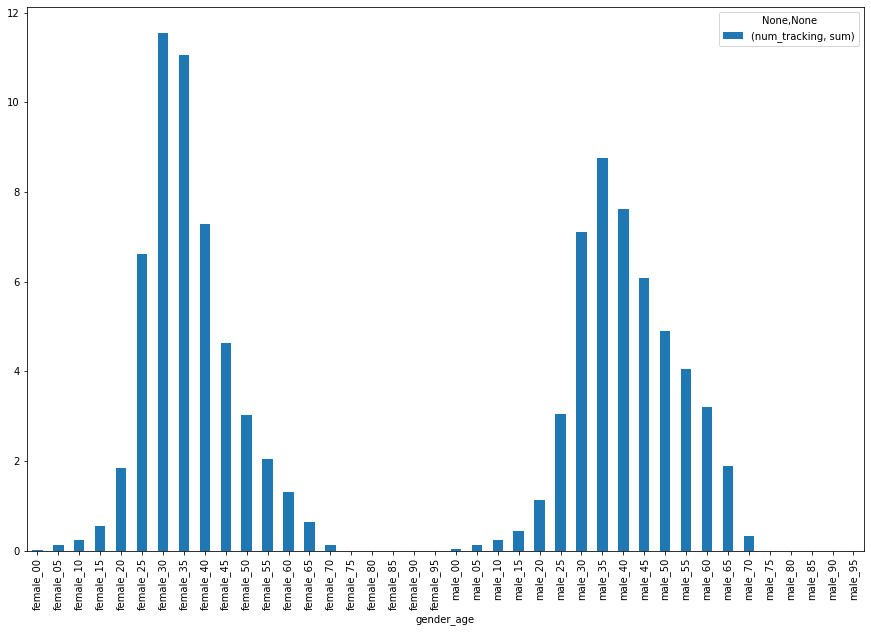

In [7]:
post_gender_age = post_base_df.loc[(post_base_df.gender_age !='unknown_00')].groupby(['gender_age'])[['num_tracking']].agg({'sum'})
post_gender_age_pcts = post_gender_age.apply(lambda x:100 *x / float(x.sum()))
ax=post_gender_age_pcts.plot(kind='bar', figsize=(15,10))

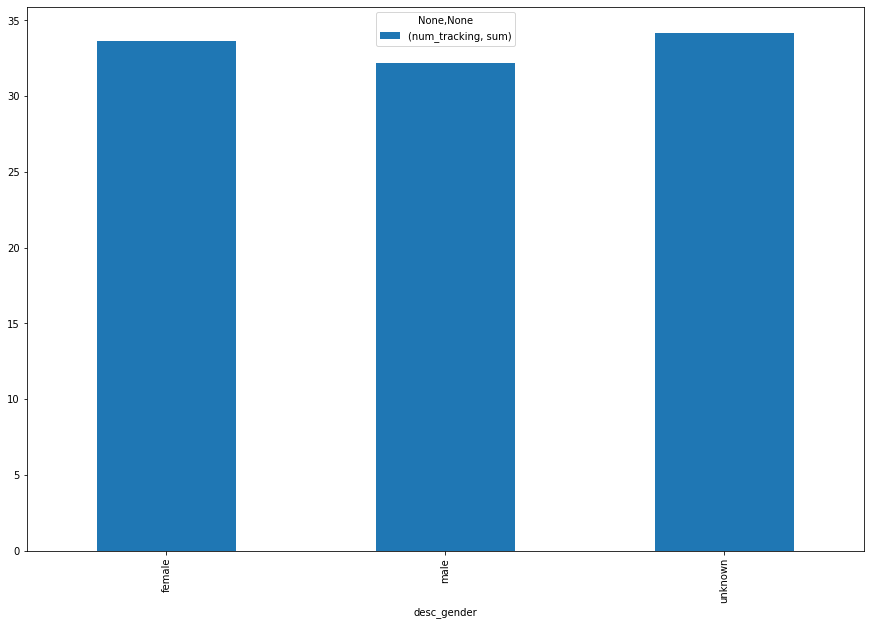

In [8]:
post_gender = post_base_df.groupby(['desc_gender'])[['num_tracking']].agg({'sum'})
post_gender_pcts = post_gender.apply(lambda x: 100*x / float(x.sum()))
ax=post_gender_pcts.plot(kind='bar', figsize=(15,10))

In [9]:
pre_base_df.head()

,calendar_dt,hour_local,calendar_dt_hour,poi_id,provider_id,target_group_id,desc_gender,desc_age,min_age,age_bucketized,is_special_dt,is_open,is_in_validation,num_tracking,prediction_type_baseline,prediction_type_evaluation,prediction_baseline,prediction_evaluation,gender_age
0,2022-03-16,0,2022-03-16 00:00,436,6,4,female,NaN,15.0,young_adults,0,1,NaN,0.0,NaN,NaN,NaN,NaN,female_15
1,2022-03-16,0,2022-03-16 00:00,514,6,4,female,NaN,15.0,young_adults,0,1,NaN,0.0,NaN,NaN,NaN,NaN,female_15
2,2022-03-16,0,2022-03-16 00:00,553,6,4,female,NaN,15.0,young_adults,0,1,NaN,0.0,NaN,NaN,NaN,NaN,female_15
3,2022-03-16,0,2022-03-16 00:00,443,6,4,female,NaN,15.0,young_adults,0,1,NaN,0.0,NaN,NaN,NaN,NaN,female_15
4,2022-03-16,0,2022-03-16 00:00,509,6,4,female,NaN,15.0,young_adults,0,1,NaN,0.0,NaN,NaN,NaN,NaN,female_15


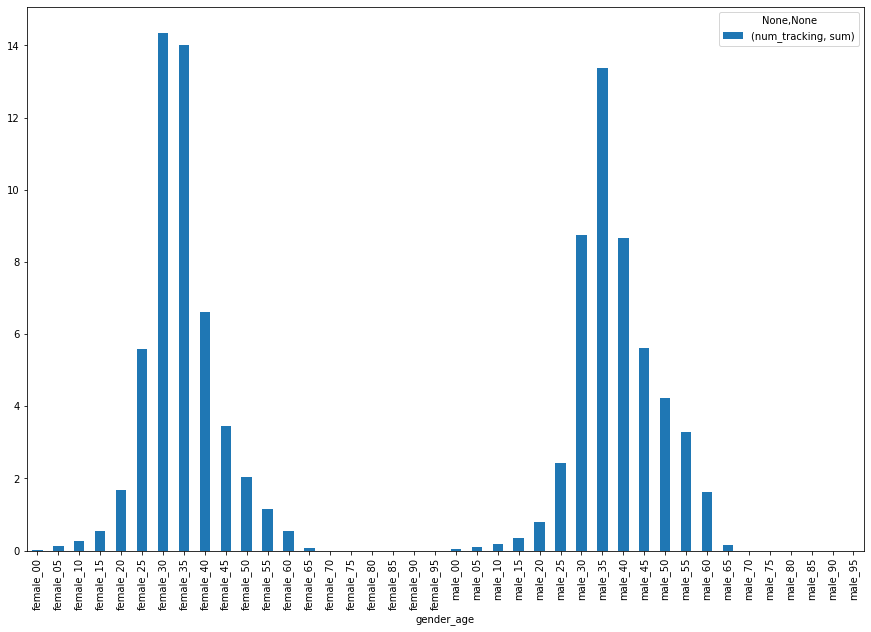

In [25]:
pre_gender_age = pre_base_df.loc[(pre_base_df.gender_age !='unknown_00') ].groupby(['gender_age'])[['num_tracking']].agg({'sum'})
pre_gender_age_pcts = pre_gender_age.apply(lambda x:  100* x / float(x.sum()))
ax=pre_gender_age_pcts.plot(kind='bar', figsize=(15,10))

In [12]:
pre_gender_age_pcts

,num_tracking
,sum
gender_age,
female_00,0.021708
female_05,0.132597
female_10,0.254120
female_15,0.549723
female_20,1.674261
female_25,5.587216
female_30,14.346297
female_35,13.999106


Text(0.5, 1.0, 'Change in Age-Gender-Distribution')

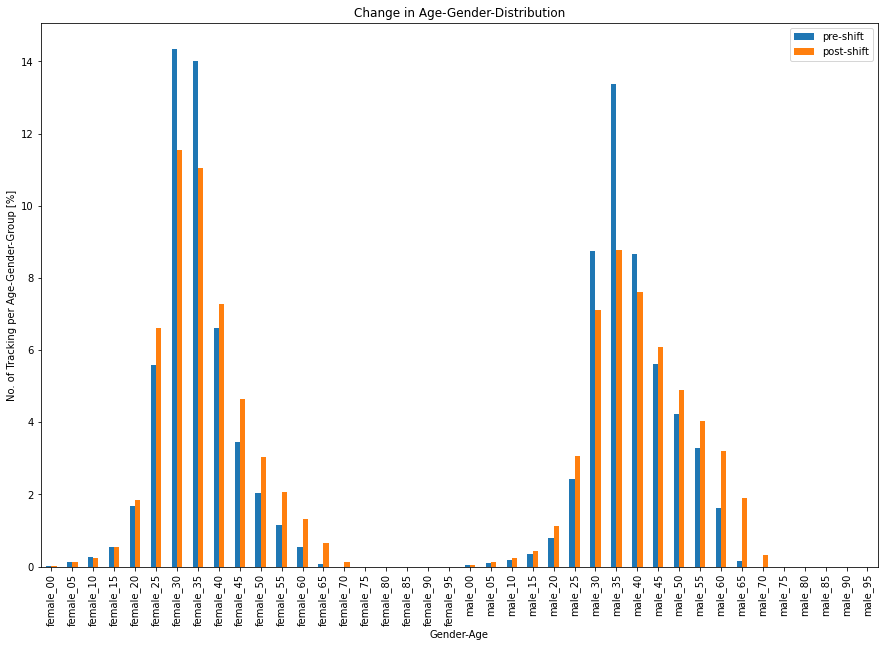

In [121]:
ax=merge_gender_age =  pre_gender_age_pcts.join(post_gender_age_pcts, how='inner', on='gender_age', lsuffix='_pre', rsuffix='_post').plot(figsize=(15,10), kind='bar')
ax.legend(labels=['pre-shift','post-shift'])
ax.set_ylabel('No. of Tracking per Age-Gender-Group [%]')
ax.set_xlabel('Gender-Age')
ax.set_title('Change in Age-Gender-Distribution')
# ax=merge_gender_age.plot(x='gender_age', y=['pre-update','post-update'],kind='bar',figsize=(15,10))


In [70]:
merge_gender_age.bar(kind='bar', figsize=(15,10))

AttributeError: 'DataFrame' object has no attribute 'bar'

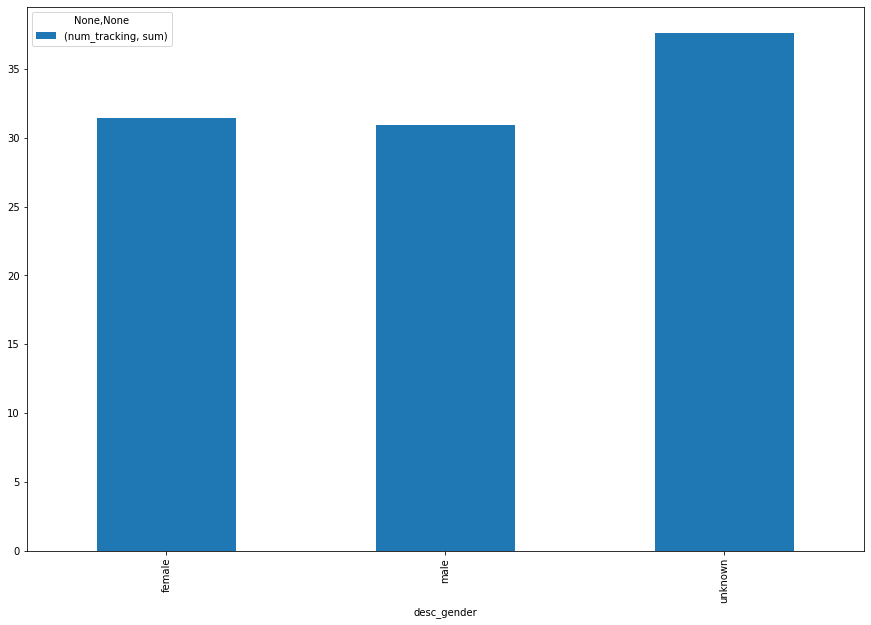

In [21]:
pre_gender = pre_base_df.groupby(['desc_gender'])[['num_tracking']].agg({'sum'})
pre_gender_pcts = pre_gender.apply(lambda x: 100*x / float(x.sum()))
ax=pre_gender_pcts.plot(kind='bar', figsize=(15,10))

<AxesSubplot:xlabel='desc_gender'>

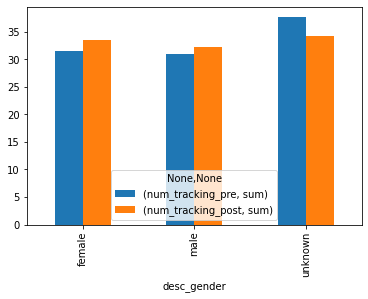

In [23]:
merge_gender = pre_gender_pcts.join(post_gender_pcts, how='inner', lsuffix='_pre', rsuffix='_post')
merge_gender.plot(kind='bar')

In [48]:
update_df.year_week.unique()

array(['202210', '202211', '202212', '202213', '202214', '202215',
       '202216', '202217', '202218', '202219', '202220', '202221'],
      dtype=object)

In [149]:
import matplotlib.patches as patches

/tmp/ipykernel_1019/2978662428.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  update_timeline = update_df.groupby('calendar_dt')['num_tracking', 'num_above_50'].agg({'sum'}).reset_index()


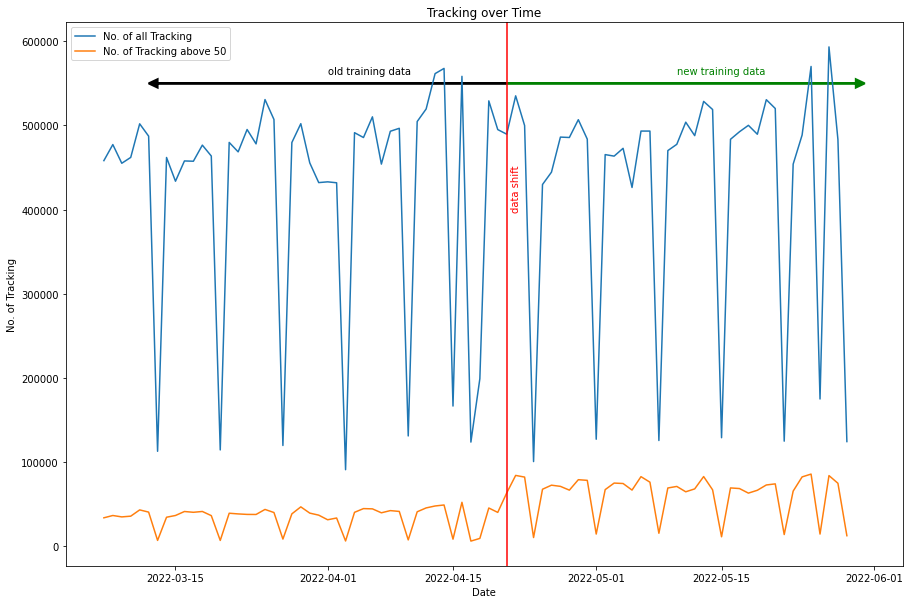

In [171]:
update_timeline = update_df.groupby('calendar_dt')['num_tracking', 'num_above_50'].agg({'sum'}).reset_index()
update_timeline.columns=['calendar_dt','num_tracking', 'num_above_50']
plt.figure(figsize=(15,10))
ax=plt.plot(update_timeline.calendar_dt, update_timeline.num_tracking, label='No. of all Tracking')
ax = plt.plot(update_timeline.calendar_dt, update_timeline.num_above_50, label='No. of Tracking above 50')
plt.ylabel('No. of Tracking')
plt.xlabel('Date')
plt.title("Tracking over Time")
plt.axvline( x=datetime.datetime(2022,4,21), color='red')
plt.text(datetime.datetime(2022,4,21,12), 400000, 'data shift', color='red', rotation=90)
plt.legend()
# patches.FancyArrowPatch((datetime.datetime(2022,4,21), 550000), (datetime.datetime(2022,5,30), 550000), arrowstyle='<->', mutation_scale=20)
plt.arrow(datetime.datetime(2022,4,21),550000,40,0, head_width=10000, head_length=1, linewidth=2, color='g',length_includes_head=True)
plt.text(datetime.datetime(2022,5,10), 560900, 'new training data', color='g')
plt.arrow(datetime.datetime(2022,4,21),550000,-40,0, head_width=10000, head_length=1, linewidth=2, color='black',length_includes_head=True)
plt.text(datetime.datetime(2022,4,1), 560900, 'old training data', color='black')


plt.show()

In [56]:
update_timeline

,year_week,num_tracking,num_above_50
0,202210,2954103,228723
1,202211,2865135,234360
2,202212,3078895,242648
3,202213,2824662,229989
4,202214,3061743,257571
5,202215,3001841,247231
6,202216,2848081,332143
7,202217,2963410,447284
8,202218,2939822,455143
9,202219,3115599,431515


In [129]:
ax=year_week.groupby('year_week_dt')['prediction_baseline','prediction_evaluation'].agg({'sum'}).plot(figsize=(15,10))
ax.legend(labels=['base-model','transfer-model'])
ax.set_ylabel('No. of Tracking')
ax.set_xlabel('Year-Week')
ax.set_title('Seasonality of Transfer-Model compared to Base-Model')


NameError: name 'year_week' is not defined

In [124]:
post_base_df.head()

,calendar_dt,hour_local,calendar_dt_hour,poi_id,provider_id,target_group_id,desc_gender,desc_age,min_age,age_bucketized,is_special_dt,is_open,is_in_validation,num_tracking,prediction_type_baseline,prediction_type_evaluation,prediction_baseline,prediction_evaluation,gender_age
0,2022-05-16,6,2022-05-16 06:00,505,6,33,male,NaN,60.0,adults,0,1,NaN,1,prediction,prediction,0.478162,0.526876,male_60
1,2022-05-16,6,2022-05-16 06:00,522,6,33,male,NaN,60.0,adults,0,1,NaN,0,prediction,prediction,0.445305,0.536574,male_60
2,2022-05-16,6,2022-05-16 06:00,543,6,33,male,NaN,60.0,adults,0,1,NaN,0,prediction,prediction,0.265008,0.509756,male_60
3,2022-05-16,6,2022-05-16 06:00,547,6,33,male,NaN,60.0,adults,0,1,NaN,0,prediction,prediction,0.008435,0.000000,male_60
4,2022-05-16,6,2022-05-16 06:00,423,6,33,male,NaN,60.0,adults,0,1,NaN,1,prediction,prediction,0.002101,0.000000,male_60


Text(0.5, 1.0, 'Forecast of Age-Gender-Distribution using Transfer Learning')

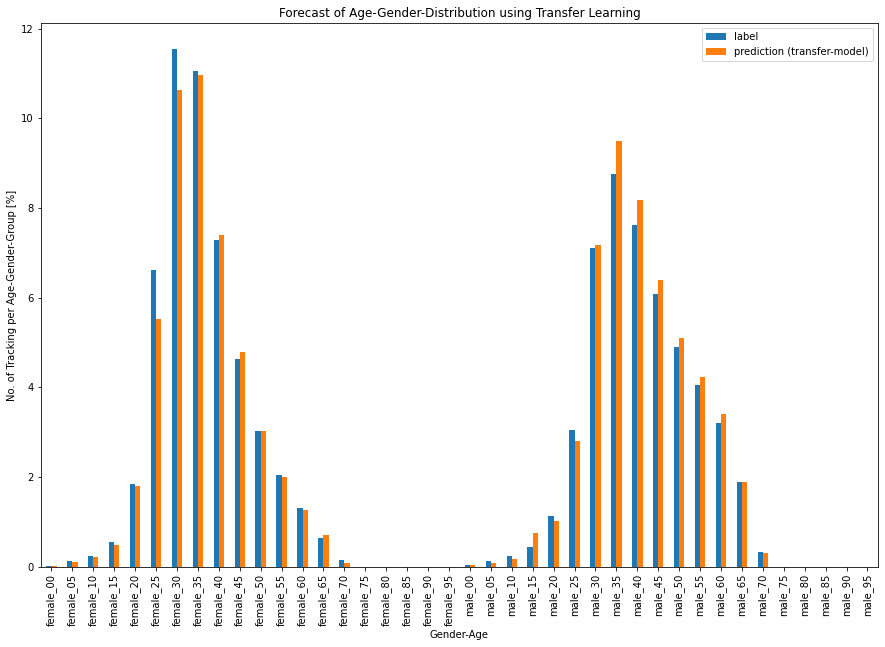

In [173]:
gender_age_model = post_base_df.loc[(post_base_df.prediction_type_evaluation=='prediction')&(post_base_df.gender_age !='unknown_00') ].groupby(['gender_age'])[['num_tracking','prediction_evaluation']].agg({'sum'})
gender_age_model_pcts = gender_age_model.apply(lambda x:  100* x / float(x.sum()))
ax=gender_age_model_pcts.plot(kind='bar', figsize=(15,10))
ax.legend(labels=['label','prediction (transfer-model)'])
ax.set_ylabel('No. of Tracking per Age-Gender-Group [%]')
ax.set_xlabel('Gender-Age')
ax.set_title('Forecast of Age-Gender-Distribution using Transfer Learning')